#imports

In [0]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
import keras
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Read axial valid set

0
(256, 256)


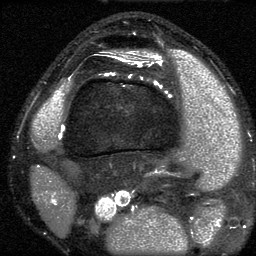

(256, 256, 3)


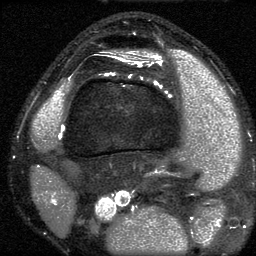

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
sagitall read


In [0]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

paths =[ "/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid/coronal/"
        ,"/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid/axial/","/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid/sagittal/"]
all_data = []
for path in paths:
  directory=[]
  for r, d, f in os.walk(path):
      for file in f:
          if '.npy' in file:
              directory.append(os.path.join(r, file))
  directory.sort()
  all_data.append(directory)

# for f in files:
#     print(f)



def to_rgb(img,i):
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA) 
#     print(img.shape)
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    if i==0:
      print(img.shape)
      cv2_imshow(img)
      print(img_rgb.shape)
      cv2_imshow(img_rgb)
#     img_rgb.shape
#     img_rgb=np.swapaxes(img_rgb,0,2)

#     print(img_rgb.shape)
    return img_rgb

# coronal=np.zeros(shape=(16649,256,256,3),dtype='uint8')
# coronalList=[]
sizes=[]
axialList=[]

k=0
# sagittalList=[]
for i in range(len(all_data[1])):
  print(i)
  a=np.load(all_data[1][i])
  f,j,k=a.shape
  sizes.append(f//2)
  for j in range(f//2):
    b=to_rgb(a[j],i+j)
    axialList.append(b)
#     coronal[k]=b
#     if i+j==0:
#       cv2_imshow(coronal[k])

  
    k+=1
    
axial=np.asarray(axialList,dtype='uint8')
axialList=None
    
# print(axial.shape)
# cv2_imshow(axial[0])

print("sagitall read")


#Read axial Labels

In [0]:
import pandas as pd
import numpy as np
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=["accuracy"])

data1 = pd.read_csv("/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid-abnormal.csv") 
data2 = pd.read_csv("/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid-acl.csv") 
data3 = pd.read_csv("/content/gdrive/My Drive/MRNet Challenge/MRNet-v1.0/valid-meniscus.csv") 
print(data1.shape)
print(data2.shape)
print(data3.shape)
# print(data1.columns)
# print(data1['1'])
print(data1)
# print(data2)
# print(data3)
# print(data1)
y1=np.array(data1["0"])
y2=np.array(data2["0"])
y3=np.array(data3["0"])
print("---------------------------------")

y1=np.hstack(('0',y1))
y2=np.hstack(('0',y2))
y3=np.hstack(('0',y3))
# print(y)
Y_train1=[]
Y_train2=[]
Y_train3=[]
for i in range(len(sizes)):
  for j in range(sizes[i]):
    Y_train1.append(y1[i])
    Y_train2.append(y2[i])
    Y_train3.append(y3[i])
 
Y_train1=np.asarray(Y_train1)
Y_train2=np.asarray(Y_train2)
Y_train3=np.asarray(Y_train3)
print(Y_train1.shape);print(Y_train2.shape);print(Y_train3.shape)


In [0]:
Y_train_1=np.zeros(shape=(2045,2));Y_train_2=np.zeros(shape=(2045,2));Y_train_3=np.zeros(shape=(2045,2))
for i in range(len(Y_train1)):
  if Y_train1[i] == '1':
    Y_train_1[i][1]=1
  elif Y_train1[i] == '0':
    Y_train_1[i][0]=1
  if Y_train2[i] == '1':
    Y_train_2[i][1]=1
  elif Y_train2[i] == '0':
    Y_train_2[i][0]=1
  if Y_train3[i] == '1':
    Y_train_3[i][1]=1
  elif Y_train3[i] == '0':
    Y_train_3[i][0]=1


#Start valuation for axial

In [0]:
#Pretrained model
img_height,img_width = 256,256 
num_classes = 2
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
# WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH_NO_TOP, cache_subdir='models', md5_hash='a268eb855778b3df3c7506639542a6af')
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
evaluation_model1 = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)

evaluation_model1.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
axial_abnormal_weights = '/content/gdrive/My Drive/axial_abnormal.5.wts.h5'
evaluation_model1.load_weights(axial_abnormal_weights)
out1=evaluation_model1.evaluate(axial, Y_train_1)
print(out1)

2045/2045 [==============================] - 11s 5ms/step
[0.5458084266423304, 0.8146699266503667]


In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
evaluation_model2 = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)

evaluation_model2.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

axial_acl_weights = '/content/gdrive/My Drive/axial_acl.5.wts.h5'
evaluation_model2.load_weights(axial_acl_weights)
out2=evaluation_model2.evaluate(axial, Y_train_2)
print(out2)


2045/2045 [==============================] - 14s 7ms/step
[0.8961945368783106, 0.583863080874049]


In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
evaluation_model3 = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)

evaluation_model3.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

axial_meniscus_weights = '/content/gdrive/My Drive/axial_meniscus.5.wts.h5'
evaluation_model3.load_weights(axial_meniscus_weights)
out3=evaluation_model3.evaluate(axial, Y_train_3)
print(out3)


2045/2045 [==============================] - 11s 5ms/step
[1.1628466485182056, 0.5466992665036675]


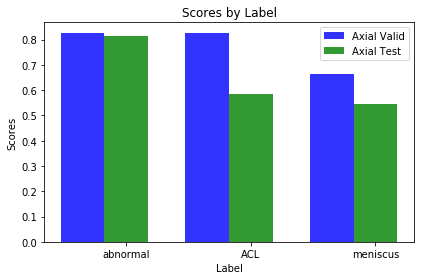

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
means_frank = (0.8246, 0.8268,0.8143)
means_guido = (0.8146699266503667, 0.583863080874049,0.5466992665036675 )

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Axial Valid')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Axial Test')

plt.xlabel('Label')
plt.ylabel('Scores')
plt.title('Scores by Label')
plt.xticks(index + bar_width, ('abnormal', 'ACL', 'meniscus'))
plt.legend()

plt.tight_layout()
plt.show()